In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pyproj
from shapely import geometry
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
"""
Create and operate on grids and profiles.

**Grid generation**

* :func:`~fatiando.gridder.regular`
* :func:`~fatiando.gridder.scatter`

**Grid operations**

* :func:`~fatiando.gridder.cut`
* :func:`~fatiando.gridder.profile`

**Interpolation**

* :func:`~fatiando.gridder.interp`
* :func:`~fatiando.gridder.interp_at`
* :func:`~fatiando.gridder.extrapolate_nans`

**Input/Output**

* :func:`~fatiando.gridder.load_surfer`: Read a Surfer grid file and return
  three 1d numpy arrays and the grid shape

**Misc**

* :func:`~fatiando.gridder.spacing`

----

"""

import numpy
import scipy.interpolate
import matplotlib.mlab


def load_surfer(fname, fmt='ascii'):
    """
    Read a Surfer grid file and return three 1d numpy arrays and the grid shape

    Surfer is a contouring, gridding and surface mapping software
    from GoldenSoftware. The names and logos for Surfer and Golden
    Software are registered trademarks of Golden Software, Inc.

    http://www.goldensoftware.com/products/surfer

    According to Surfer structure, x and y are horizontal and vertical
    screen-based coordinates respectively. If the grid is in geographic
    coordinates, x will be longitude and y latitude. If the coordinates
    are cartesian, x will be the easting and y the norting coordinates.

    WARNING: This is opposite to the convention used for Fatiando.
    See io_surfer.py in cookbook.

    Parameters:

    * fname : str
        Name of the Surfer grid file
    * fmt : str
        File type, can be 'ascii' or 'binary'

    Returns:

    * x : 1d-array
        Value of the horizontal coordinate of each grid point.
    * y : 1d-array
        Value of the vertical coordinate of each grid point.
    * grd : 1d-array
        Values of the field in each grid point. Field can be for example
        topography, gravity anomaly etc
    * shape : tuple = (ny, nx)
        The number of points in the vertical and horizontal grid dimensions,
        respectively

    """
    assert fmt in ['ascii', 'binary'], "Invalid grid format '%s'. Should be \
        'ascii' or 'binary'." % (fmt)
    if fmt == 'ascii':
        # Surfer ASCII grid structure
        # DSAA            Surfer ASCII GRD ID
        # nCols nRows     number of columns and rows
        # xMin xMax       X min max
        # yMin yMax       Y min max
        # zMin zMax       Z min max
        # z11 z21 z31 ... List of Z values
        with open(fname) as ftext:
            # DSAA is a Surfer ASCII GRD ID
            id = ftext.readline()
            # Read the number of columns (nx) and rows (ny)
            nx, ny = [int(s) for s in ftext.readline().split()]
            # Read the min/max value of x (columns/longitue)
            xmin, xmax = [float(s) for s in ftext.readline().split()]
            # Read the min/max value of  y(rows/latitude)
            ymin, ymax = [float(s) for s in ftext.readline().split()]
            # Read the min/max value of grd
            zmin, zmax = [float(s) for s in ftext.readline().split()]
            data = numpy.fromiter((float(i) for line in ftext for i in
                                   line.split()), dtype='f')
            grd = numpy.ma.masked_greater_equal(data, 1.70141e+38)
        # Create x and y numpy arrays
        x = numpy.linspace(xmin, xmax, nx)
        y = numpy.linspace(ymin, ymax, ny)
        x, y = [tmp.ravel() for tmp in numpy.meshgrid(x, y)]
    if fmt == 'binary':
        raise NotImplementedError(
            "Binary file support is not implemented yet.")
    return x, y, grd, (ny, nx)

def regular(area, shape, z=None):
    """
    Create a regular grid. Order of the output grid is x varies first, then y.

    Parameters:

    * area
        ``(x1, x2, y1, y2)``: Borders of the grid
    * shape
        Shape of the regular grid, ie ``(ny, nx)``.
    * z
        Optional. z coordinate of the grid points. If given, will return an
        array with the value *z*.

    Returns:

    * ``[xcoords, ycoords]``
        Numpy arrays with the x and y coordinates of the grid points
    * ``[xcoords, ycoords, zcoords]``
        If *z* given. Numpy arrays with the x, y, and z coordinates of the grid
        points

    """
    ny, nx = shape
    x1, x2, y1, y2 = area
    dy, dx = spacing(area, shape)
    x_range = numpy.arange(x1, x2, dx)
    y_range = numpy.arange(y1, y2, dy)
    # Need to make sure that the number of points in the grid is correct
    # because of rounding errors in arange. Sometimes x2 and y2 are included,
    # sometimes not
    if len(x_range) < nx:
        x_range = numpy.append(x_range, x2)
    if len(y_range) < ny:
        y_range = numpy.append(y_range, y2)
    assert len(x_range) == nx, "Failed! x_range doesn't have nx points"
    assert len(y_range) == ny, "Failed! y_range doesn't have ny points"
    xcoords, ycoords = [mat.ravel()
                        for mat in numpy.meshgrid(x_range, y_range)]
    if z is not None:
        zcoords = z * numpy.ones_like(xcoords)
        return [xcoords, ycoords, zcoords]
    else:
        return [xcoords, ycoords]

def scatter(area, n, z=None, seed=None):
    """
    Create an irregular grid with a random scattering of points.

    Parameters:

    * area
        ``(x1, x2, y1, y2)``: Borders of the grid
    * n
        Number of points
    * z
        Optional. z coordinate of the points. If given, will return an
        array with the value *z*.
    * seed : None or int
        Seed used to generate the pseudo-random numbers. If `None`, will use a
        different seed every time. Use the same seed to generate the same
        random points.

    Returns:

    * ``[xcoords, ycoords]``
        Numpy arrays with the x and y coordinates of the points
    * ``[xcoords, ycoords, zcoords]``
        If *z* given. Arrays with the x, y, and z coordinates of the points

    """
    x1, x2, y1, y2 = area
    numpy.random.seed(seed)
    xcoords = numpy.random.uniform(x1, x2, n)
    ycoords = numpy.random.uniform(y1, y2, n)
    numpy.random.seed()
    if z is not None:
        zcoords = z * numpy.ones(n)
        return [xcoords, ycoords, zcoords]
    else:
        return [xcoords, ycoords]

def spacing(area, shape):
    """
    Returns the spacing between grid nodes

    Parameters:

    * area
        ``(x1, x2, y1, y2)``: Borders of the grid
    * shape
        Shape of the regular grid, ie ``(ny, nx)``.

    Returns:

    * ``[dy, dx]``
        Spacing the y and x directions

    """
    x1, x2, y1, y2 = area
    ny, nx = shape
    dx = float(x2 - x1) / float(nx - 1)
    dy = float(y2 - y1) / float(ny - 1)
    return [dy, dx]

def interp(x, y, v, shape, area=None, algorithm='cubic', extrapolate=False):
    """
    Interpolate data onto a regular grid.

    Parameters:

    * x, y : 1D arrays
        Arrays with the x and y coordinates of the data points.
    * v : 1D array
        Array with the scalar value assigned to the data points.
    * shape : tuple = (ny, nx)
        Shape of the interpolated regular grid, ie (ny, nx).
    * area : tuple = (x1, x2, y1, y2)
        The are where the data will be interpolated. If None, then will get the
        area from *x* and *y*.
    * algorithm : string
        Interpolation algorithm. Either ``'cubic'``, ``'nearest'``,
        ``'linear'`` (see scipy.interpolate.griddata), or ``'nn'`` for nearest
        neighbors (using matplotlib.mlab.griddata)
    * extrapolate : True or False
        If True, will extrapolate values outside of the convex hull of the data
        points.

    Returns:

    * ``[x, y, v]``
        Three 1D arrays with the interpolated x, y, and v

    """
    if algorithm not in ['cubic', 'linear', 'nearest', 'nn']:
        raise ValueError("Invalid interpolation algorithm: " + str(algorithm))
    ny, nx = shape
    if area is None:
        area = (x.min(), x.max(), y.min(), y.max())
    x1, x2, y1, y2 = area
    xs = numpy.linspace(x1, x2, nx)
    ys = numpy.linspace(y1, y2, ny)
    xp, yp = [i.ravel() for i in numpy.meshgrid(xs, ys)]
    if algorithm == 'nn':
        grid = matplotlib.mlab.griddata(x, y, v, numpy.reshape(xp, shape),
                                        numpy.reshape(yp, shape),
                                        interp='nn').ravel()
        if extrapolate and numpy.ma.is_masked(grid):
            grid = extrapolate_nans(xp, yp, grid)
    else:
        grid = interp_at(x, y, v, xp, yp, algorithm=algorithm,
                         extrapolate=extrapolate)
    return [xp, yp, grid]


def interp_at(x, y, v, xp, yp, algorithm='cubic', extrapolate=False):
    """
    Interpolate data onto the specified points.

    Parameters:

    * x, y : 1D arrays
        Arrays with the x and y coordinates of the data points.
    * v : 1D array
        Array with the scalar value assigned to the data points.
    * xp, yp : 1D arrays
        Points where the data values will be interpolated
    * algorithm : string
        Interpolation algorithm. Either ``'cubic'``, ``'nearest'``,
        ``'linear'`` (see scipy.interpolate.griddata)
    * extrapolate : True or False
        If True, will extrapolate values outside of the convex hull of the data
        points.

    Returns:

    * v : 1D array
        1D array with the interpolated v values.

    """
    if algorithm not in ['cubic', 'linear', 'nearest']:
        raise ValueError("Invalid interpolation algorithm: " + str(algorithm))
    grid = scipy.interpolate.griddata((x, y), v, (xp, yp),
                                      method=algorithm).ravel()
    if extrapolate and algorithm != 'nearest' and numpy.any(numpy.isnan(grid)):
        grid = extrapolate_nans(xp, yp, grid)
    return grid

def profile(x, y, v, point1, point2, size, extrapolate=False):
    """
    Extract a data profile between 2 points.

    Uses interpolation to calculate the data values at the profile points.

    Parameters:

    * x, y : 1D arrays
        Arrays with the x and y coordinates of the data points.
    * v : 1D array
        Array with the scalar value assigned to the data points.
    * point1, point2 : lists = [x, y]
        Lists the x, y coordinates of the 2 points between which the profile
        will be extracted.
    * size : int
        Number of points along the profile.
    * extrapolate : True or False
        If True, will extrapolate values outside of the convex hull of the data
        points.

    Returns:

    * [xp, yp, distances, vp] : 1d arrays
        ``xp`` and ``yp`` are the x, y coordinates of the points along the
        profile.
        ``distances`` are the distances of the profile points to ``point1``
        ``vp`` are the data points along the profile.

    """
    x1, y1 = point1
    x2, y2 = point2
    maxdist = numpy.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    distances = numpy.linspace(0, maxdist, size)
    angle = numpy.arctan2(y2 - y1, x2 - x1)
    xp = x1 + distances * numpy.cos(angle)
    yp = y1 + distances * numpy.sin(angle)
    vp = interp_at(x, y, v, xp, yp, algorithm='cubic', extrapolate=extrapolate)
    return xp, yp, distances, vp


def extrapolate_nans(x, y, v):
    """"
    Extrapolate the NaNs or masked values in a grid INPLACE using nearest
    value.

    .. warning:: Replaces the NaN or masked values of the original array!

    Parameters:

    * x, y : 1D arrays
        Arrays with the x and y coordinates of the data points.
    * v : 1D array
        Array with the scalar value assigned to the data points.

    Returns:

    * v : 1D array
        The array with NaNs or masked values extrapolated.

    """
    if numpy.ma.is_masked(v):
        nans = v.mask
    else:
        nans = numpy.isnan(v)
    notnans = numpy.logical_not(nans)
    v[nans] = scipy.interpolate.griddata((x[notnans], y[notnans]), v[notnans],
                                         (x[nans], y[nans]),
                                         method='nearest').ravel()
    return v


def cut(x, y, scalars, area):
    """
    Return a subsection of a grid.

    The returned subsection is not a copy! In technical terms, returns a slice
    of the numpy arrays. So changes made to the subsection reflect on the
    original grid. Use numpy.copy to make copies of the subsections and avoid
    this.

    Parameters:

    * x, y
        Arrays with the x and y coordinates of the data points.
    * scalars
        List of arrays with the scalar values assigned to the grid points.
    * area
        ``(x1, x2, y1, y2)``: Borders of the subsection

    Returns:

    * ``[subx, suby, subscalars]``
        Arrays with x and y coordinates and scalar values of the subsection.

    """
    xmin, xmax, ymin, ymax = area
    if len(x) != len(y):
        raise ValueError("x and y must have the same length")
    inside = [i for i in xrange(len(x))
              if x[i] >= xmin and x[i] <= xmax
              and y[i] >= ymin and y[i] <= ymax]
    return [x[inside], y[inside], [s[inside] for s in scalars]]

In [3]:
magraw_atest = pd.read_csv('../../../database/csv/mag/mag_atest.csv')
gamaraw_atest = pd.read_csv('../../../database/csv/gama/gama_atest.csv')

In [5]:
gamaraw_atest['geometry'] = [geometry.Point(x, y) for x, y in zip(gamaraw_atest['X'], gamaraw_atest['Y'])]
crs = "+proj=utm +zone=21 +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
gamaraw_atest = gpd.GeoDataFrame(gamaraw_atest, geometry='geometry', crs=crs)
gamaraw_atest.head(100)

,Unnamed: 0,KPERC,eU,eTH,UTHRAZAO,X,Y,UKRAZAO,MDT,THKRAZAO,CTCOR,LATITUDE,LONGITUDE,geometry
0,0,1.02,1.11,13.00,0.1,292878.15,7624109.00,0.9,600.12,9.86,23.0,-21.473638,-46.998997,POINT (292878.150 7624109.000)
1,1,1.47,1.09,13.53,0.1,292876.59,7624190.38,0.8,599.47,9.77,24.2,-21.472903,-46.999002,POINT (292876.590 7624190.380)
2,2,1.82,1.15,14.97,0.1,292875.03,7624271.94,0.8,600.63,9.81,25.3,-21.472167,-46.999007,POINT (292875.030 7624271.940)
3,3,1.52,1.22,14.94,0.1,292874.16,7624353.33,0.7,602.72,9.96,25.5,-21.471432,-46.999005,POINT (292874.160 7624353.330)
4,4,1.34,1.15,13.11,0.1,292873.81,7624434.72,0.7,602.21,10.18,24.5,-21.470697,-46.998998,POINT (292873.810 7624434.720)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.42,1.03,12.71,0.1,292879.56,7631856.82,1.7,596.17,20.09,18.9,-21.403678,-46.998030,POINT (292879.560 7631856.820)
96,96,0.26,1.03,11.31,0.1,292879.24,7631935.81,1.8,599.09,21.22,18.1,-21.402965,-46.998023,POINT (292879.240 7631935.810)
97,97,0.31,0.94,11.22,0.1,292878.24,7632014.80,1.9,603.28,22.36,18.5,-21.402252,-46.998023,POINT (292878.240 7632014.800)
98,98,0.28,0.97,10.40,0.1,292877.23,7632093.78,2.0,606.98,23.35,19.0,-21.401538,-46.998023,POINT (292877.230 7632093.780)


In [9]:
magraw_atest['geometry'] = [geometry.Point(x, y) for x, y in zip(magraw_atest['X'], magraw_atest['Y'])]
crs = "+proj=utm +zone=21 +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
magraw_atest = gpd.GeoDataFrame(magraw_atest, geometry='geometry', crs=crs)
magraw_atest.head(100)

,Unnamed: 0,X,Y,MDT,LATITUDE,LONGITUDE,MAGCOM,MAGCOR,MAGIGRF,MAGMIC,MAGNIV,geometry
0,0,292879.66,7624043.90,609.44,-21.474226,-46.998990,23154.640,23123.693,49.882,23113.580,23119.835,POINT (292879.660 7624043.900)
1,1,292879.49,7624052.04,609.53,-21.474153,-46.998991,23155.182,23124.236,50.469,23114.171,23120.439,POINT (292879.490 7624052.040)
2,2,292879.32,7624060.18,609.60,-21.474079,-46.998991,23155.734,23124.789,50.987,23114.677,23120.958,POINT (292879.320 7624060.180)
3,3,292879.15,7624068.32,609.66,-21.474006,-46.998992,23156.180,23125.236,51.473,23115.181,23121.473,POINT (292879.150 7624068.320)
4,4,292878.98,7624076.47,609.71,-21.473932,-46.998993,23156.659,23125.715,51.945,23115.658,23121.963,POINT (292878.980 7624076.470)
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,292875.91,7624816.99,602.45,-21.467245,-46.998931,23067.344,23036.446,-38.866,23025.277,23032.544,POINT (292875.910 7624816.990)
96,96,292876.05,7624825.15,602.33,-21.467172,-46.998929,23066.365,23035.468,-39.895,23024.253,23031.524,POINT (292876.050 7624825.150)
97,97,292876.18,7624833.31,602.22,-21.467098,-46.998926,23065.414,23034.517,-40.851,23023.303,23030.577,POINT (292876.180 7624833.310)
98,98,292876.32,7624841.47,602.12,-21.467024,-46.998924,23064.628,23033.731,-41.762,23022.396,23029.676,POINT (292876.320 7624841.470)


### Criando Grid da folhaE 

In [49]:
# creating a grid with cells 76 x 125m
xu, yu = regular(shape = (390,105),area = (292583.362379, 344777.003253,7.608264e+06, 7.637882e+06))

In [50]:
sx, sy = spacing(shape = (390,105),
                    area = (292583.362379, 344777.003253, 
                             7.608264e+06, 7.637882e+06))

In [51]:
print(sx, sy)

76.1388174807198 501.861931480769


### Interpolando os dados com os pontos recem gridados

#### Interpolando mag

In [52]:
x1, y1 = np.array(magraw_atest.X), np.array(magraw_atest.Y)

In [53]:
MAGIGRF = np.array(magraw_atest.MAGIGRF)

In [54]:
magigrf = interp_at(x1, y1, MAGIGRF, xu, yu, algorithm = 'cubic', extrapolate = True)

In [55]:
MDT = np.array(magraw_atest.MDT)

In [56]:
mdt = interp_at(x1, y1, MDT, xu, yu, algorithm = 'cubic', extrapolate = True)

#### Interpolando gama

In [57]:
x2, y2 = np.array(gamaraw_atest.X), np.array(gamaraw_atest.Y)

In [58]:
KPERC = np.array(gamaraw_atest.KPERC)
kperc = interp_at(x2, y2, KPERC, xu, yu, algorithm = 'cubic', extrapolate = True)

In [59]:
eU = np.array(gamaraw_atest.eU)
eu = interp_at(x2, y2, eU, xu, yu, algorithm = 'cubic', extrapolate = True)

In [60]:
eTH = np.array(gamaraw_atest.eTH)
eth = interp_at(x2, y2, eTH, xu, yu, algorithm = 'cubic', extrapolate = True)

In [61]:
CTCOR = np.array(gamaraw_atest.CTCOR)
ctcor = interp_at(x2, y2, CTCOR, xu, yu, algorithm = 'cubic', extrapolate = True)


In [62]:
UTHRAZAO = np.array(gamaraw_atest.UTHRAZAO)
uthrazao = interp_at(x2, y2, UTHRAZAO, xu, yu, algorithm = 'cubic', extrapolate = True)


In [63]:
UKRAZAO = np.array(gamaraw_atest.UKRAZAO)
ukrazao = interp_at(x2, y2, UKRAZAO, xu, yu, algorithm = 'cubic', extrapolate = True)


In [64]:
THKRAZAO = np.array(gamaraw_atest.THKRAZAO)
thkrazao = interp_at(x2, y2, THKRAZAO, xu, yu, algorithm = 'cubic', extrapolate = True)


In [65]:
# intialise data of lists. 
data = {'X':xu, 'Y':yu, 'MDT': mdt, 'MAGIGRF': magigrf, 'KPERC': kperc, 'eU':eu, 'eTh': eth, 'CTCOR': ctcor,
        'THKRAZAO': thkrazao, 'UKRAZAO': ukrazao,'UTHRAZAO': uthrazao} 
  
# Create DataFrame 
geo_data = pd.DataFrame(data) 
  
# Print the output. 
geo_data.head(1000)

,X,Y,MDT,MAGIGRF,KPERC,eU,eTh,CTCOR,THKRAZAO,UKRAZAO,UTHRAZAO
0,292583.362379,7.608264e+06,887.303185,-40.968565,0.970660,1.128581,10.539510,17.923289,9.509484,0.877646,0.103536
1,293085.224310,7.608264e+06,887.303185,-40.968565,0.970660,1.128581,10.539510,17.923289,9.509484,0.877646,0.103536
2,293587.086242,7.608264e+06,860.123808,-83.694924,2.251217,-0.612836,15.069250,18.841135,11.850299,0.533476,-0.045593
3,294088.948173,7.608264e+06,860.123808,-83.694924,2.251217,-0.612836,15.069250,18.841135,11.850299,0.533476,-0.045593
4,294590.810105,7.608264e+06,782.272213,-78.347328,2.251217,-0.612836,15.069250,18.841135,11.850299,0.533476,-0.045593
...,...,...,...,...,...,...,...,...,...,...,...
995,317676.458953,7.608949e+06,1135.166960,50.294714,1.451327,1.549295,18.462954,31.206928,13.136517,1.095995,0.098786
996,318178.320885,7.608949e+06,1145.090119,138.718756,1.411627,1.046826,14.160676,20.480802,11.384388,0.993638,0.100331
997,318680.182816,7.608949e+06,1202.559515,60.204016,1.177473,1.612307,15.599081,26.131255,10.045189,1.021499,0.099361
998,319182.044747,7.608949e+06,1237.463655,36.223665,0.600808,1.583043,15.297905,28.799500,22.214084,2.779754,0.102106


<AxesSubplot:>

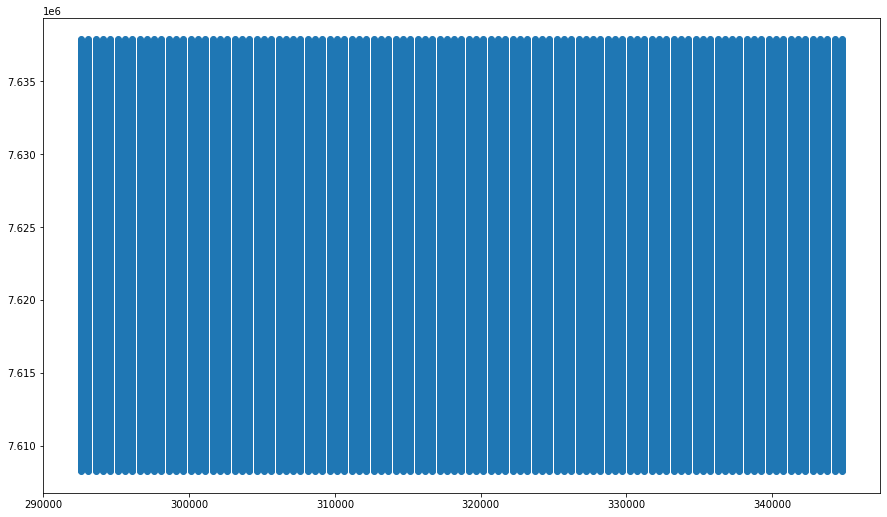

In [67]:
geo_data['geometry'] = [geometry.Point(x, y) for x, y in zip(geo_data['X'], geo_data['Y'])]
crs = "+proj=utm +zone=21 +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
geo_data = gpd.GeoDataFrame(geo_data, geometry='geometry', crs=crs)
geo_data.head(100)
geo_data.plot(figsize=(15,15))

In [68]:
geo_data.to_csv('../../../database/csv/interpolado/data_atest.csv')